# setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp
from tensorflow.keras import layers
import keras
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TerminateOnNaN
from scipy.stats import boxcox
from tqdm.auto import tqdm
import MCMC_fun as mf
import util_fun as uf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

2025-08-01 02:33:31.233151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 02:33:31.248128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754030011.261092 2145501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754030011.265000 2145501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754030011.277905 2145501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import importlib
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

# HP tuning

## pre-processing

In [2]:
run_name = 'box_coal_qn_4ma_hill_growth_46_momvals_targetBOSS'
filename = run_name + '_N5000_dt5.0_test.nc'

params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler_asinh'
x_train, x_val, y_train, y_val, tgt_data, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=True, set_nan_to_neg1001=True)

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']

Transforming data...: 100%|██████████| 3/3 [05:16<00:00, 105.42s/it]
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/py

In [4]:
# fig = plt.figure(figsize=(15, 5))
# gs = gridspec.GridSpec(1,nvar)
# for i, eff0 in enumerate(eff0s):
#     ax = fig.add_subplot(gs[i])
#     _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
#                  bins=100,
#                  density=True,
#                  label=['BOSS PPE', 'target'])
#     plt.legend()
#     # plt.yscale('log')
#     plt.title(var_constraints[i])

Next, try out different ML architectures...

## CRPS

In [17]:
import importlib
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

Transforming data...: 100%|██████████| 3/3 [00:13<00:00,  4.50s/it]
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1098: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/pyt

In [9]:
np.min(y_train['water_0']), np.max(y_train['water_0'])

(np.float64(nan), np.float64(nan))

In [25]:
tf.subtract(tf.expand_dims(y_train['water_0'], -1),tf.expand_dims(y_train['water_0'], -2)).shape

2025-07-31 18:58:01.011018: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.36TiB (rounded to 27885772800000)requested by op Sub
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-31 18:58:01.011075: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-07-31 18:58:01.011091: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 126, Chunks in use: 126. 31.5KiB allocated for chunks. 31.5KiB in use in bin. 544B client-requested in use in bin.
2025-07-31 18:58:01.011103: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 40, Chunks in use: 39. 20.8KiB allocated for chunks. 20.0KiB in use in bin. 15.2KiB client-requested in use in bin.
2025-

ResourceExhaustedError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sub] name: 

In [ ]:
import importlib
importlib.reload(ef)
importlib.reload(tu)

crps_net = tu.build_crps_network(nvar, nparam_init, nobs, l_has_presence=False, learn_rate=0.005)
crps_net.summary()

monitor = keras.callbacks.EarlyStopping(monitor='val_loss',
                         min_delta=0.0, patience=4, verbose=1,
                         mode='auto', restore_best_weights=True)
crps_net.fit(x=x_train, y=y_train, 
             batch_size=128,
             callbacks=[monitor],
             epochs=100,
             validation_data=(x_val, y_val),
             verbose=1)


Model: "crps_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 14)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L1 (Dense)          │ (None, 100)       │      1,500 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L2 (Dense)          │ (None, 100)       │     10,100 │ L1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L3 (Dense)          │ (None, 100)       │     10,100 │ L2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_0 (Dense)     │ (None, 29520)     │  2,981,520 │ L3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_1 (Dense)     │ (None, 29520)     │  2,981,520 │ L3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_2 (Dense)     │ (None, 29520)     │  2,981,520 │ L3[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,966,260 (34.20 MB)

 Trainable params: 8,966,260 (34.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - loss: nan - water_0_loss: nan - water_1_loss: nan - water_2_loss: nan

KeyboardInterrupt: 

In [24]:
from properscoring import crps_ensemble

In [30]:
x_val.shape

(1000, 14)

In [ ]:
crps_loss = crps_net.evaluate(x_val, y_val)
y_pred = crps_net.predict(x_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: -68.6598 - water_0_loss: -22.7640 - water_1_loss: -22.9364 - water_2_loss: -22.9592
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/properscoring/_crps.py:257: SyntaxWarning: invalid escape sequence '\i'
  CRPS(F, x) = \int_z (F(z) - H(z - x))^2 dz


TypeError: unsupported operand type(s) for -: 'dict' and 'dict'

In [39]:
crps_score

array([[514.4708252 , 450.44909668, 502.1340332 , ...,   8.7293211 ,
         10.48099953,   0.81098594],
       [556.02148438, 490.24377441, 543.37084961, ...,  11.02094476,
         12.79793639,   1.21633042],
       [408.45153809, 348.89624023, 396.98583984, ...,   8.19196094,
          9.80194105,   0.69877121],
       ...,
       [646.49279785, 576.86804199, 633.08679199, ...,   9.70652101,
         11.62176566,   0.64770098],
       [161.26721191, 112.17028809, 151.82714844, ...,   6.54904457,
          7.87078798,   0.76310278],
       [275.52880859, 221.59216309, 265.13537598, ...,   9.47739093,
         10.95651722,   1.42670983]])

In [37]:
crps_loss

[-68.70311737060547,
 -22.778907775878906,
 -22.947263717651367,
 -22.97303581237793]

In [38]:
crps_score = crps_ensemble(y_val['water_0'], y_pred['water_0'])
print("Model Loss: {:.4f}".format(crps_loss[0]))
print("Mean Model CRPS Score: {:.4f}".format(crps_score.mean()))


Model Loss: -68.7031
Mean Model CRPS Score: 11.6343


## multi-head (implicit) model

In [6]:
nobs = [i.shape[1] for i in ppe_var_presence]
nvar = len(ppe_var_presence)

proj_name = 'multihead_' + run_name + transform_method

tuner = kt.RandomSearch(
    lambda hp: tu.build_multihead_model(hp, nparam_init, nvar, nobs),
    objective="val_loss",
    max_trials=25,
    directory=lp.bossppe_dir+'/hp_tuning/multi-head',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    y_train_rawv,
    epochs=25,
    validation_data=(x_val, y_val_rawv),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

NameError: name 'ppe_var_presence' is not defined

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

# y_train_list = y_train_wpresence + y_train_rawv
# y_val_list   = y_val_wpresence   + y_val_rawv

history = best_model.fit(
    x=x_train,
    y=y_train_rawv,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val_rawv),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

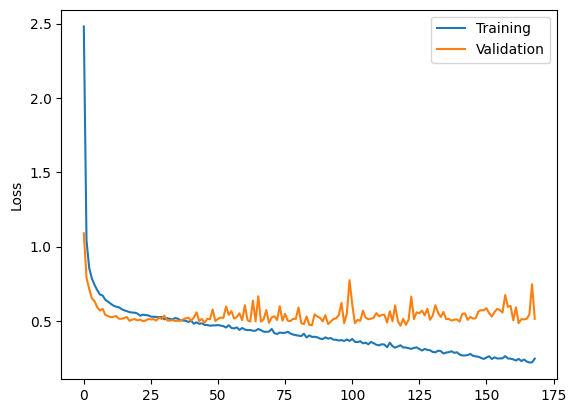

In [ ]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# save model:
best_model.save(lp.bossppe_dir + '/models/' + proj_name + '.keras')

In [ ]:
ef.

## multi-output (explicit) model

In [ ]:
# import importlib
# importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [3]:
proj_name = 'multioutput_' + run_name + '_' + transform_method

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    # lambda hp: tu.build_classreg_fallspeed_model(hp, nparam_init, nvar, nobs),
    lambda hp: tu.build_classreg_model(hp, nparam_init, nvar, nobs, l_dropout=True),
    objective="val_loss",
    max_trials=25,
    directory=lp.bossppe_dir+'/hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 01m 02s]
val_loss: 3.132936716079712

Best val_loss So Far: 0.47020965814590454
Total elapsed time: 00h 28m 03s


In [4]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(lp.bossppe_dir + '/models/' + proj_name + '.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2025-08-01 03:30:48.742838: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 4 bytes spill stores, 4 bytes spill loads



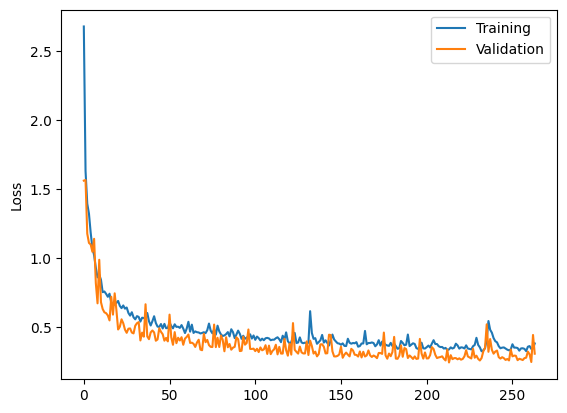

In [5]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

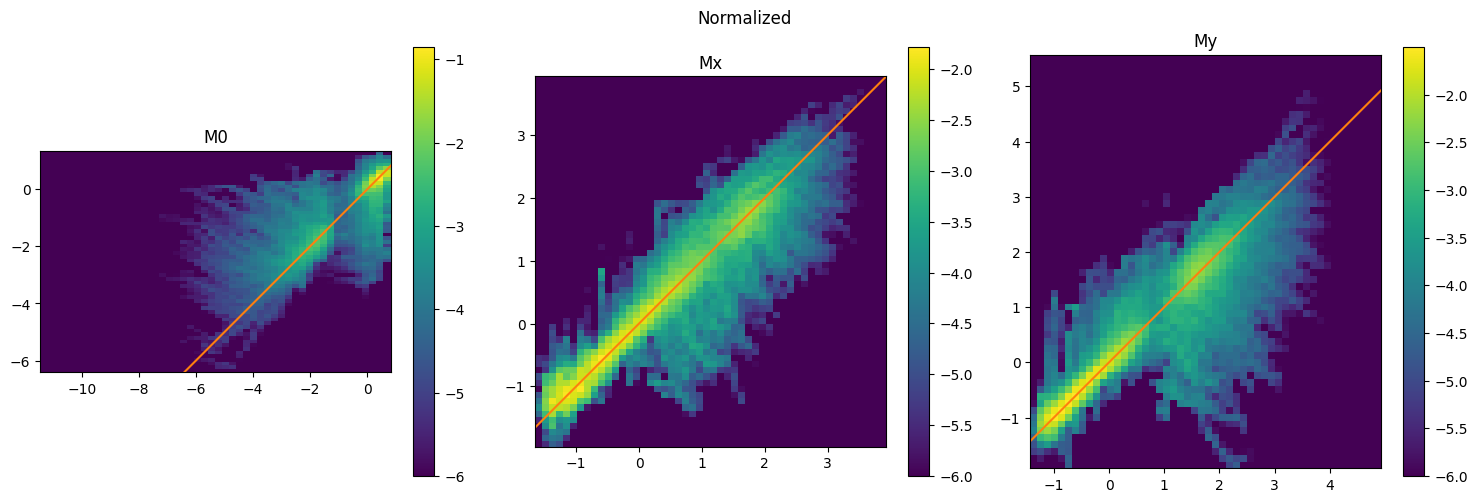

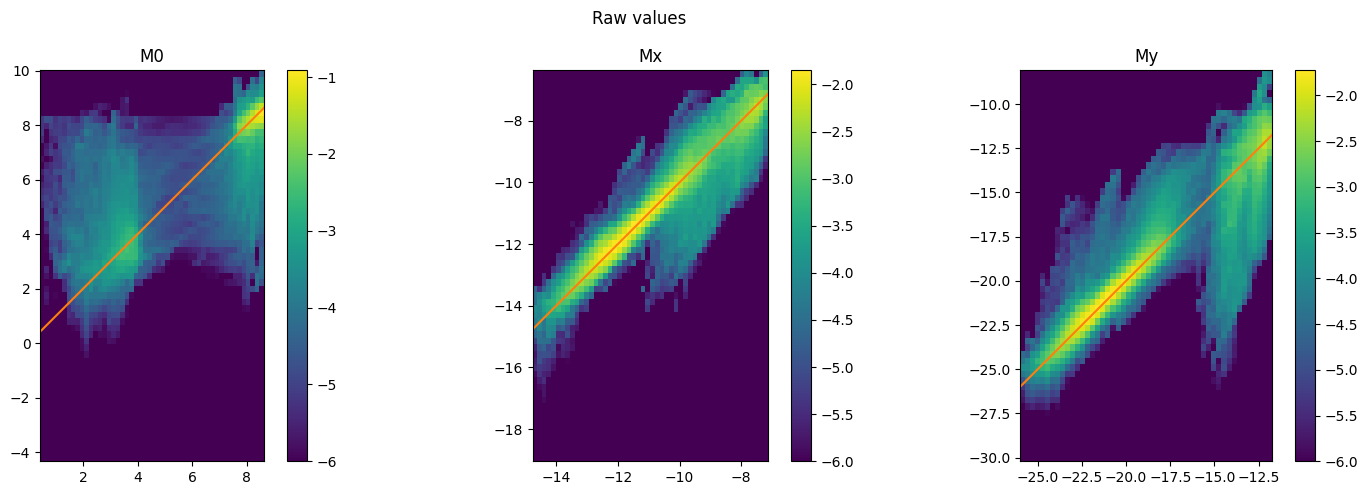

In [8]:
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=False)

## MC dropout

In [6]:
import importlib
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

In [3]:
y_train.keys()

dict_keys(['water_0', 'presence_0', 'water_1', 'presence_1', 'water_2', 'presence_2'])

In [5]:
proj_name = 'mcdropout_' + run_name + '_' + transform_method

tuner = kt.RandomSearch(
    # lambda hp: tu.build_classreg_fallspeed_model(hp, nparam_init, nvar, nobs),
    lambda hp: tu.build_mc_dropout_model(hp, nparam_init, nvar, nobs),
    objective="val_loss",
    max_trials=25,
    directory=lp.bossppe_dir+'/hp_tuning/mcdropout',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 2 Complete [00h 00m 08s]
val_loss: nan

Best val_loss So Far: nan
Total elapsed time: 00h 00m 16s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |4                 |num_shared_layers
0.1               |0.1               |dropout_rate
256               |32                |units_0
7.9657e-05        |1.1637e-05        |adam_lr
224               |32                |units_1
256               |32                |units_2
256               |32                |units_3

Epoch 1/25
  1/125 ━━━━━━━━━━━━━━━━━━━━ 6:17 3s/step - loss: 6.3759 - presence_0_accuracy: 0.0000e+00 - presence_0_loss: 0.6932 - presence_1_accuracy: 0.0000e+00 - presence_1_loss: 0.6933 - presence_2_accuracy: 0.0000e+00 - presence_2_loss: 0.6931 - water_0__masked_mae: 0.8512 - water_0_loss: 1.5274 - water_1__masked_mae: 1.0166 - water_1_loss: 1.3362 - water_2__masked_mae: 1.0291 - water_2_loss: 1.4328Batch 1: Invalid loss, terminating training
125/125 ━━━━━━━━━━━━━━━━━━━━

RuntimeError: Number of consecutive failures exceeded the limit of 3.


## validation

In [6]:
proj_name = 'multioutput_unc_min-2_box_coal_qn_4ma_hill_growth_46_momvals_targetBOSS_standard_scaler_asinh'
best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)
# proj_name


/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1000, 14))
  warnings.warn(msg)
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1000, 14))
  warnings.warn(msg)
/home/arthurhu/miniconda3/envs/BOSS_PPE/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1000, 14))
  warnings.warn(msg)


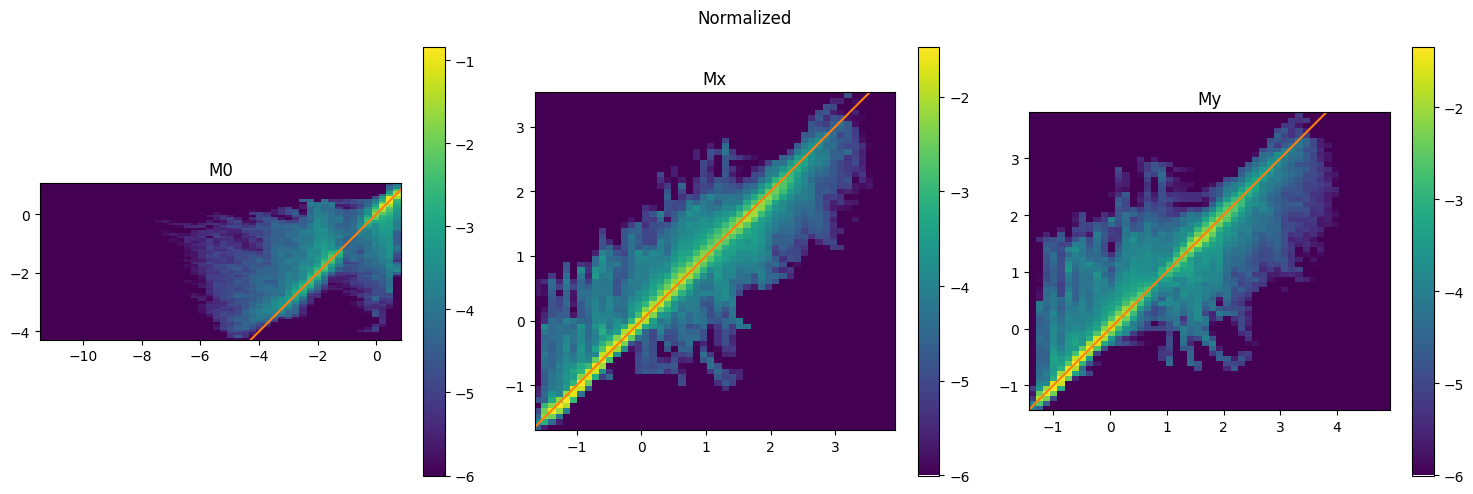

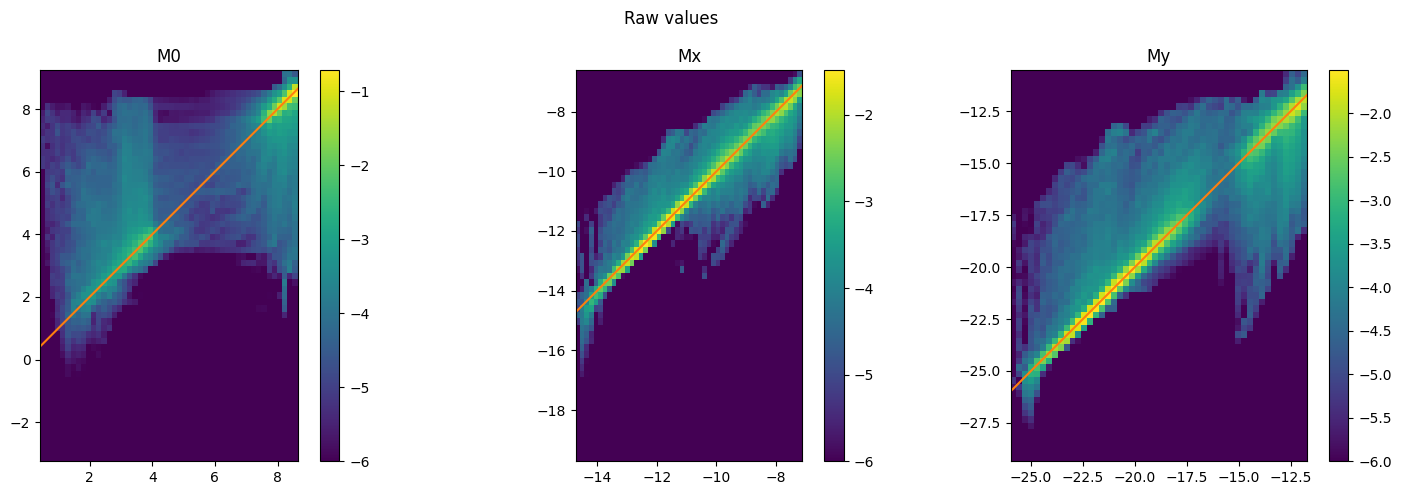

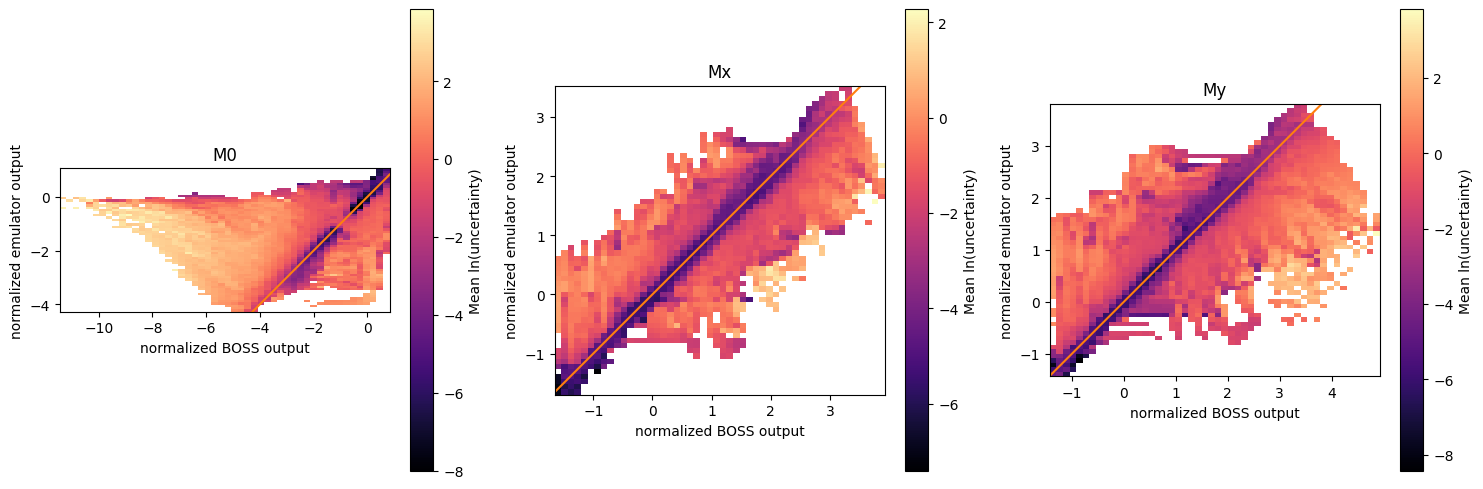

In [27]:
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=True)

In [7]:
# List top memory variables
# top_vars = uf.get_top_memory_vars(globals())
uf.detailed_memory_analysis()
# # Free likely iterated/temporary variables
# free_iterated_vars(locals())

# # Optionally, show top memory variables again after cleanup
# print("\nAfter cleanup:")
# get_top_memory_vars(locals())

=== Memory Analysis ===
RSS (Resident Set Size): 4.40 GB
VMS (Virtual Memory Size): 54.19 GB
Shared Memory: 0.56 GB
Text Segment: 0.00 GB
Data Segment: 13.32 GB

⚠️  Large VMS-RSS gap: 49.79 GB
This might indicate memory fragmentation or external libraries


# MCMC

## setup

In [181]:
# proj_name = 'multioutput_box_coal_qn_4ma_hill_growth_46_mompaths_targetBOSS_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [7]:
import importlib
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

In [8]:
tgt_data_tf32 = tf.cast(tgt_data, tf.float32)
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = '/home/arthurhu/CloudBOSS/param_csv/param_consolid_simPL_coal3046_4ma_hill_growth_fall3046_hill_indv_mlim.csv'
target_param_csv = '/home/arthurhu/CloudBOSS/param_csv/param_test.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()

target_param_table = pd.read_csv(target_param_csv)

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[1, 1+param_interest_idx].astype(np.float32)
target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

print_table = pd.DataFrame({'param names': param_names, 'prior mean': param_mean, 'target mean': target_param_mean})
print(print_table)

   param names  prior mean  target mean
0    a0coal_db  -86.872787   -90.872787
1       bmcoal    1.114888     1.314888
2      bn0coal    2.176518     2.076518
3      bnxcoal    2.110249     2.210248
4      bnycoal    2.040299     2.440299
5      bx0coal    0.955827     0.755827
6      bxxcoal    1.416141     1.216141
7      bxycoal    2.409513     2.009513
8      by0coal    0.767179     0.967179
9      byxcoal    2.012912     2.512912
10     byycoal    3.901877     3.001877
11  mtrans0_db   -5.051001    -8.051001


In [9]:
tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

## run

In [28]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
ADJUST_WEIGHT = False
if ADJUST_WEIGHT:
    weighted_str = '_weighted_'
else:
    weighted_str = ''

exp_rate = 1

nchains = 6
# ratio_obs = 1/np.sqrt(tgt_data_tf32.numpy().size/tgt_data_tf32.shape[0])
# ratio_obs = 1/np.sqrt(tgt_data_tf32.shape[-1])
ratio_obs = 1/np.sqrt(tgt_data_tf32.numpy().size)

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :, :], [nchains, 1, 1, 1])
valid_mask = tf.math.is_finite(tgt_data_tf32)
tgt_valid = tf.stack([tgt_data_tf32_chain[i, ...][valid_mask] for i in range(nchains)])

def get_BOSSemu_lp(params_sigma, l_diag=False):
    # priors on parameters
    emu_tf32_presence_list = []
    emu_tf32_water_list = []
    emu_tf32_unc_list = []

    params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta=tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0,0,:].numpy())

    # # priors on sigma
    # log_sigma = params_sigma[:,-1]
    # sigma = tf.exp(log_sigma)
    # sigma_lp = tfd.Exponential(rate=exp_rate).log_prob(sigma) + log_sigma
    # sigma_expanded = sigma[:, None]

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    # if l_diag:
        # print('unscaled parameters:', minmaxscale.inverse_transform(input_norm3d[0,...])[0,n_init:])
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i in range(nvar):
            emu_tf32_presence_list.append(tf.cast(y_emu[f'presence_{i}'], tf.float32))
            emu_tf32_water_list.append(tf.cast(y_emu[f'water_{i}'][:,:nobs[i]], tf.float32))
            emu_tf32_unc_list.append(tf.cast(y_emu[f'water_{i}'][:,nobs[i]:], tf.float32))
        emu_tf32_presence = tf.concat(emu_tf32_presence_list, axis=1)
        emu_tf32_water = tf.concat(emu_tf32_water_list, axis=1)
        emu_tf32_unc = tf.concat(emu_tf32_unc_list, axis=1)
        emu_tf32 = emu_tf32_presence * emu_tf32_water
        # emu_tf32_unc = emu_tf32_unc * emu_tf32_water
    else:
        emu_tf32 = tf.cast(y_emu, tf.float32)
    emu_tf32_chain = tf.transpose(tf.reshape(emu_tf32, [nvar, nchains, n_tgt_ics, nobs[i]]), [1,0,2,3])
    emu_tf32_unc_chain = tf.transpose(tf.reshape(emu_tf32_unc, [nvar, nchains, n_tgt_ics, nobs[i]]), [1,0,2,3])
    emu_valid = tf.stack([emu_tf32_chain[i, ...][valid_mask] for i in range(nchains)])
    emu_valid_unc = tf.exp(0.5*tf.stack([emu_tf32_unc_chain[i, ...][valid_mask] for i in range(nchains)]))
    # print(emu_valid_unc)
    obs_lp = tf.reduce_sum(tfd.Normal(loc=tgt_valid, scale=emu_valid_unc).log_prob(emu_valid), axis=1)

    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', ratio_obs * obs_lp.numpy().mean())
        print('mean emu_valid_unc:', emu_valid_unc.numpy().mean())
        return param_lp, ratio_obs * obs_lp #, sigma_lp
    else:
        return param_lp + ratio_obs * obs_lp # + sigma_lp

In [29]:
target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
target_chain = tf.cast(tf.tile(target1d[None, :], [nchains, 1]), tf.float32)
a = get_BOSSemu_lp(target_chain, l_diag=True)
print(a)
# initial_state = tf.zeros([nchains, npar])
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], 0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], -0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)

scaled parameters: [0.34684163 0.6207668  0.4232784  0.57523143 0.78892225 0.39328137
 0.41204312 0.36606365 0.580444   0.6593699  0.28888467 0.43503547]
param_lp: -1277.7465 obs_lp: -2293982.1172884875
mean emu_valid_unc: 0.07847991
(<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-1277.7465, -1277.7465, -1277.7465, -1277.7465, -1277.7465,
       -1277.7465], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ -548280.8 ,  -544032.44, -5789633.5 ,  -548280.8 ,  -544032.44,
       -5789633.5 ], dtype=float32)>)


### actual run

In [16]:
N_post = tf.math.is_finite(tgt_data_tf32).numpy().sum()
N_prior = n_tgt_ics * npar

tf.random.set_seed(0)

exp_rate = 1.
# batched_BOSSemu_lp = lambda params_batch: tf.vectorized_map(get_BOSSemu_lp, params_batch)
num_burnin_steps = 1000
num_samples = 2000
initial_state = tf.random.normal([nchains, npar], seed=1)
# initial_state = tf.concat([tf.random.normal([nchains, npar]),
#                            tf.zeros([nchains, 1])], axis=1)

stepsize = 0.01

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=int(num_burnin_steps * 0.5),
    target_accept_prob=0.75,
    )

nuts = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=get_BOSSemu_lp, step_size=stepsize, max_tree_depth=10)
adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts,
    num_adaptation_steps=int(num_burnin_steps * 0.5),
    target_accept_prob=0.65,
)

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=adaptive_hmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

samples, kr = run_chain()

end = time.time()
print(end-start)

410.7185277938843


acceptance rate: [1. 0. 0. 0. 0. 1.]


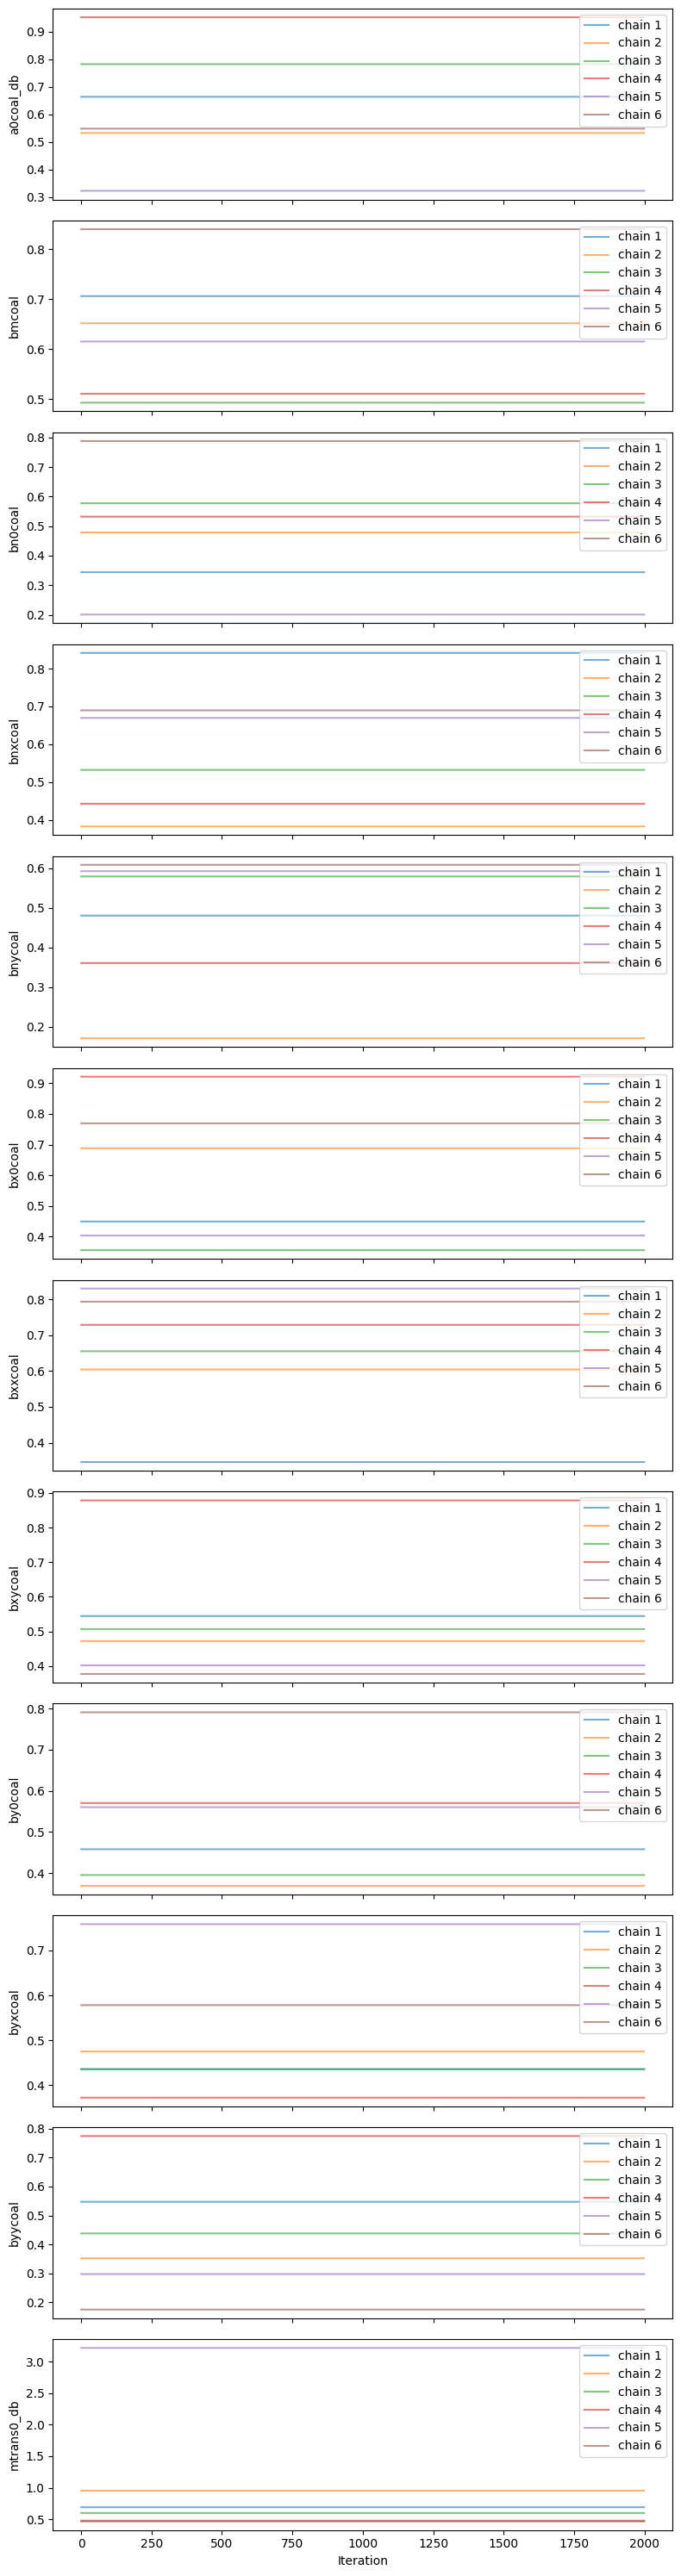

[[1.        1.        1.        1.        1.        1.              nan
        nan 1.        1.        1.              nan]
 [      nan       nan       nan 0.9999999       nan 1.        1.
        nan 1.        1.              nan 1.       ]
 [1.        1.        1.              nan 1.              nan       nan
        nan 1.              nan       nan 1.       ]
 [      nan       nan       nan       nan 1.              nan       nan
  1.        1.        1.        1.        1.       ]
 [1.              nan       nan       nan       nan       nan 1.
        nan 1.        1.              nan 1.       ]
 [      nan       nan 1.        1.              nan       nan 1.
  1.        1.              nan 1.        1.       ]]
[6.5564261e+13 2.9146883e+13 1.9364143e+13 2.0759959e+13 9.7467698e+12
 4.4612694e+12 2.0897333e+13 8.1242855e+13 7.2137247e+13 5.7525936e+13
 1.5851918e+13 5.1902016e+13]


In [17]:
print("acceptance rate:", sum(kr.inner_results.is_accepted.numpy())/num_samples)
param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
mf.plot_traces(transformed_samples, param_names_incl_sigma)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [18]:
print("acc rate:", kr.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.new_step_size.numpy().min(), kr.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.log_accept_ratio))

acc rate: 0.3333333333333333
step_size range: 0.0 0.0
avg log_accept_ratio: -1024528.56


In [19]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 68563910.0


## postprocessing

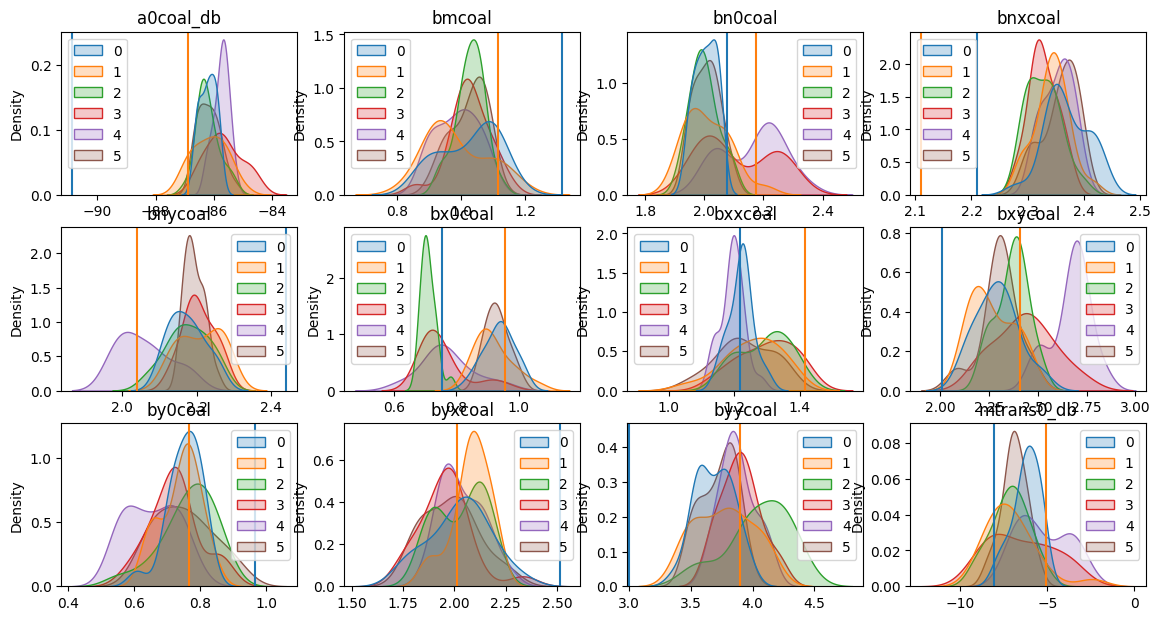

In [332]:
import seaborn as sns

IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
# IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples[:,:,:-1]], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = minmaxscale.inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)

$$
\frac{dM_i}{dt} \propto a_{0,coal}M^2_0\frac{\tilde{m}^{b_{n,i}}}{\tilde{m}^{b_{m}} + m_{trans}^{b_m}}K^{b_{x,i}}_{0,3,x}K^{b_{y,i}}_{3,x,y}
$$

x=4, y=6 for ith order moment

## validation

In [327]:
target_param_mean_2d.shape, target_pwIC_norm.shape
target_param_model = best_model(target_pwIC_norm)

In [ ]:
tsamples_combine_chains = transformed_samples[:,:,:-1].numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)
vars_after_MCMC_norm = best_model(meanresults_incl_ics)
target_param_model = best_model(target_pwIC_norm)

y_pred_inv = []
y_true_inv = []
y_tgt_model_inv = []
y_pred = []
y_true = []
y_tgt_model = []

for i in range(nvar):
    if type(vars_after_MCMC_norm) is dict:
        presence = vars_after_MCMC_norm['presence'][i].numpy()
        presence[presence<0.1] = 0.
        if 'V_M' in var_constraints[i]:
            y_pred_inv.append(presence * minmaxscales[i].inverse_transform(vars_after_MCMC_norm['water'][i].numpy().astype('float64')))
            y_true_inv.append(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')))
        else:
            if transform_method == 'meanboxcox':
                y_pred_inv.append(presence * ef.inv_boxcox(standard_scales[i].inverse_transform(vars_after_MCMC_norm['water'][i].numpy().astype('float64')), mean_lams[i]))
                y_true_inv.append(ef.inv_boxcox(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), mean_lams[i]))
            elif transform_method == 'standard_scaler_asinh':
                y_pred_inv.append(presence * ef.inv_smooth_linlog(standard_scales[i].inverse_transform(vars_after_MCMC_norm['water'][i].numpy().astype('float64')), eff0s[i]))
                y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
            elif transform_method == 'minmaxscale_asinh':
                y_pred_inv.append(presence * ef.inv_smooth_linlog(minmaxscales[i].inverse_transform(vars_after_MCMC_norm['water'][i].numpy().astype('float64')), eff0s[i]))
                y_true_inv.append(ef.inv_smooth_linlog(minmaxscales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
            elif transform_method == 'standard_scaler_log':
                y_pred_inv.append(presence * 10**(standard_scales[i].inverse_transform(vars_after_MCMC_norm['water'][i].numpy().astype('float64'))))
                y_true_inv.append(presence * 10**(standard_scales[i].inverse_transform(tgt_data[i].astype('float64'))))
        y_pred.append(vars_after_MCMC_norm['water'][i].numpy().astype('float64'))
    else:
        y_pred_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(vars_after_MCMC_norm[i].numpy().astype('float64')), eff0s[i]))
        y_true_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(tgt_data[i].astype('float64')), eff0s[i]))
        y_tgt_model_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(target_param_model[i].numpy().astype('float64')), eff0s[i]))
        y_pred.append(vars_after_MCMC_norm[i].numpy().astype('float64'))
    y_true.append(tgt_data[i].astype('float64'))
    y_tgt_model.append(target_param_model[i].numpy().astype('float64'))

# y_true_inv[0][y_true_inv[0]<1e-4] = np.nan

nrow = int(np.ceil(nvar/3))
fig = plt.figure(figsize=(15,5*nrow))
gs = gridspec.GridSpec(nrow,3)

idx=5

for i, (yt_tmp, yp_tmp) in enumerate(zip(y_tgt_model_inv, y_pred_inv)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    # vpoint = np.logical_and(np.isfinite(yt_tmp), np.isfinite(yp_tmp))
    # hist, xedges, yedges = np.histogram2d(yt_tmp[vpoint], yp_tmp[vpoint], bins=[50, 60])

    vpoint = np.logical_and(yt_tmp>0., yp_tmp>0.)
    hist, xedges, yedges = np.histogram2d(np.log10(yt_tmp[vpoint]), np.log10(yp_tmp[vpoint]), bins=[50, 60])
    hist_min = 1e-6
    hist = hist/hist.sum()
    hist = np.log10(np.maximum(hist, hist_min)).T
    plt.pcolor(xedges, yedges, hist, cmap='viridis', shading='auto')
    plt.colorbar(label='log10(PDF)', ax=ax)

    # plt.scatter(yt_tmp, yp_tmp, alpha=0.01)
    ax = plt.gca()
    # if i==0:
    #     ax.set_xlim([1e-3, 1e8])
    #     ax.set_ylim([1e-3, 1e8])
    # ax.set_aspect('equal')
    # ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    # ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    ax_min = max([ax.get_ylim()[0]] + [ax.get_xlim()[0]])
    ax_max = min([ax.get_ylim()[1]] + [ax.get_xlim()[1]])
    plt.plot([ax_min, ax_max], [ax_min, ax_max], color='tab:orange')
    plt.xlabel('BIN')
    plt.ylabel('BOSS PPE')
    plt.title('log10(' + var_constraints[i] + ')')
    # if i>3:
    # plt.xscale('log')
    # plt.yscale('log')

fig.savefig('plots/MCMC_' + proj_name + weighted_str + '.png')

for i, eff0 in enumerate(eff0s):
    y_pred_inv[i][y_pred_inv[i]<=0] = np.nan
    y_true_inv[i][y_true_inv[i]<=0] = np.nan
    fig = plt.figure(figsize=(8, 6))
    _ = plt.hist([np.log10(y_pred_inv[i]).flatten(), np.log10(y_true_inv[i]).flatten()], 
                 bins=100, 
                 density=True,
                 label=['emulated BOSS', 'BIN'])
    plt.xlabel('log10(' + var_constraints[i] + ')')
    plt.legend()

KeyError: 0

In [ ]:
y_true_inv

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])]

# Save MCMC results

## save posterior PDF into netCDF

In [ ]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + filename[:-3] + '_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## update params csv

In [ ]:
original_params = pd.read_csv(orig_param_csv + '.csv')
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(orig_param_csv + run_name + '_r1.csv', index=False)
updated_params